In [1]:
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from collections import defaultdict, Counter
from datetime import timedelta
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from numba import jit
import ds_helpers as dh
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Create combined df

In [3]:
train['is_test'] = 0
test['is_test'] = 1
df_data = pd.concat([train, test])
col_order = [
    'reservation_id', 'booking_date', 'checkin_date', 'checkout_date', 'channel_code', 'main_product_code',
    'numberofadults','numberofchildren', 'persontravellingid', 'resort_region_code', 'resort_type_code',
    'room_type_booked_code', 'roomnights', 'season_holidayed_code', 'state_code_residence', 'state_code_resort',
    'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid', 'cluster_code', 'reservationstatusid_code',
    'resort_id', 'amount_spent_per_room_night_scaled', 'is_test'
]
df_data = df_data[col_order]
df_data.reset_index(drop=True, inplace=True)

### Replace null in categorical variables by -999

In [4]:
missing_data_columns = ['season_holidayed_code', 'state_code_residence']

for col in missing_data_columns:
    df_data[col].fillna(-999, inplace=True)

### Convert date strs to datetime

In [5]:
df_data['booking_date'] = pd.to_datetime(df_data['booking_date'], format='%d/%m/%y')
df_data['checkin_date'] = pd.to_datetime(df_data['checkin_date'], format='%d/%m/%y')
df_data['checkout_date'] = pd.to_datetime(df_data['checkout_date'], format='%d/%m/%y')

### Clean the data

In [6]:
corrected_checkin_dates = df_data[df_data['booking_date'] > df_data['checkin_date']]['checkin_date'].apply(
    lambda x: x - timedelta(46)
)
df_data.loc[df_data['booking_date'] > df_data['checkin_date'], 'booking_date'] = corrected_checkin_dates

### Date features

In [7]:
date_columns = ['booking_date', 'checkin_date', 'checkout_date']

for date_col in date_columns:
    df_data[f'{date_col}_date'] = df_data[date_col].apply(lambda x: x.day)
    df_data[f'{date_col}_month'] = df_data[date_col].apply(lambda x: x.month)
    df_data[f'{date_col}_year'] = df_data[date_col].apply(lambda x: x.year)
    df_data[f'{date_col}_week_of_year'] = df_data[date_col].apply(lambda x: x.week)
    df_data[f'{date_col}_week_of_month'] = df_data[date_col].apply(lambda x: ((x.day-1) // 7) + 1)
    df_data[f'{date_col}_day_of_week'] = df_data[date_col].apply(lambda x: x.dayofweek + 1)
    df_data[f'{date_col}_is_weekend'] = df_data[date_col].apply(lambda x: x.dayofweek in [5, 6])
    df_data[f'{date_col}_is_weekend_including_friday'] = df_data[date_col].apply(lambda x: x.dayofweek in [4, 5, 6])

In [8]:
df_data['days_between_booking_and_checkin'] = (df_data['checkin_date'] - df_data['booking_date']).dt.days

In [9]:
df_data['duration_of_stay'] = (df_data['checkout_date'] - df_data['checkin_date']).dt.days

### Other features

In [10]:
df_data['total_people'] = df_data['numberofadults'] + (0.5 * df_data['numberofchildren'])

#### Total people 0 doesn't make much sense, change that to 1

In [11]:
df_data.loc[df_data['total_people'] == 0, 'total_people'] = 1.0

In [12]:
df_data['total_people*duration'] = df_data['total_people'] * df_data['duration_of_stay']

In [13]:
df_data['resort_type_room_type'] = \
df_data['resort_type_code'].astype(str) + '_' + df_data['room_type_booked_code'].astype(str)

In [14]:
df_data['resortid_main_product_code'] = \
df_data['resort_id'].astype(str) + '_' + df_data['main_product_code'].astype(str)

df_data['resortid_room_type_booked_code'] = \
df_data['resort_id'].astype(str) + '_' + df_data['room_type_booked_code'].astype(str)

df_data['resort_type_main_product_code'] = \
df_data['resort_type_code'].astype(str) + '_' + df_data['main_product_code'].astype(str)

df_data['resort_region_main_product_code'] = \
df_data['resort_region_code'].astype(str) + '_' + df_data['main_product_code'].astype(str)

df_data['resort_state_code_residence'] = \
df_data['resort_id'].astype(str) + '_' + df_data['state_code_residence'].astype(str)

df_data['resort_member_age_buckets'] = \
df_data['resort_id'].astype(str) + '_' + df_data['member_age_buckets'].astype(str)

In [15]:
df_data['diff_between_booked_and_actual_days'] = df_data['roomnights'] - df_data['duration_of_stay']

In [16]:
df_data['state_code_residence'] = df_data['state_code_residence'].apply(lambda x: int(x))

In [17]:
df_data['is_resort_in_same_state'] = (df_data['state_code_residence'] == df_data['state_code_resort']).astype(int)

In [18]:
df_data['diff_between_expected_and_actual_pax'] = \
(df_data['total_pax'] - df_data['numberofadults'] - df_data['numberofchildren'])

In [19]:
checkin_dates = df_data['checkin_date'].apply(lambda x: x.date())
checkout_dates = df_data['checkout_date'].apply(lambda x: x.date())

weekend_counts = []
weekend_counts_including_friday = []

for checkin_date,checkout_date in zip(checkin_dates, checkout_dates):
    weekend_counts.append(np.busday_count(checkin_date, checkout_date, weekmask='0000011'))
    weekend_counts_including_friday.append(np.busday_count(checkin_date, checkout_date, weekmask='0000111'))

In [20]:
df_data['weekend_count'] = weekend_counts
df_data['weekend_count_including_friday'] = weekend_counts_including_friday

### Label Encoding

In [21]:
for col in df_data.columns :
    if df_data[col].dtypes == 'object' and col != 'reservation_id':
        print(col)
        le = LabelEncoder()
        df_data[col] = le.fit_transform(df_data[col])

member_age_buckets
memberid
cluster_code
reservationstatusid_code
resort_id
resort_type_room_type
resortid_main_product_code
resortid_room_type_booked_code
resort_type_main_product_code
resort_region_main_product_code
resort_state_code_residence
resort_member_age_buckets


### Count features

In [22]:
df_data.sort_values('checkin_date', inplace=True)
df_data.reset_index(drop=True, inplace=True)

In [23]:
def get_expanding_count(iterable):
    expanding_count = []
    count_dict = defaultdict(np.int32)
    for elem in iterable:
        if elem in count_dict:
            count_dict[elem] += 1
            expanding_count.append(count_dict[elem])
        else:
            count_dict[elem] = 1
            expanding_count.append(1)

    return expanding_count, count_dict

In [24]:
def get_expanding_count_in_year(iterable, year_iterable):
    expanding_count = []
    count_dict = defaultdict(np.int32)
    for elem,year in zip(iterable, year_iterable):
        key = f'{elem}||{year}'
        if key in count_dict:
            count_dict[key] += 1
            expanding_count.append(count_dict[key])
        else:
            count_dict[key] = 1
            expanding_count.append(1)

    return expanding_count, count_dict

In [25]:
def get_expanding_count_in_month(iterable, year_iterable, month_iterable):
    expanding_count = []
    count_dict = defaultdict(np.int32)
    for elem,year,month in zip(iterable, year_iterable, month_iterable):
        key = f'{elem}||{year}||{month}'
        if key in count_dict:
            count_dict[key] += 1
            expanding_count.append(count_dict[key])
        else:
            count_dict[key] = 1
            expanding_count.append(1)

    return expanding_count, count_dict

In [26]:
df_data['user_id_count'] = df_data['memberid'].map(Counter(df_data['memberid']))
df_data['user_id_expanding_count'] = get_expanding_count(df_data['memberid'])[0]
df_data['user_id_expanding_count_year'] = get_expanding_count_in_year(
    df_data['memberid'], df_data['checkin_date_year']
)[0]
df_data['user_id_expanding_count_month'] = get_expanding_count_in_month(
    df_data['memberid'], df_data['checkin_date_year'], df_data['checkin_date_month']
)[0]

In [27]:
df_data['user_resort'] = df_data['memberid'].astype(str) + '_' + df_data['resort_id'].astype(str)
df_data['user_resort_count'] = df_data['user_resort'].map(Counter(df_data['user_resort']))
df_data['user_resort_expanding_count'] = get_expanding_count(df_data['user_resort'])[0]
df_data['user_resort_expanding_count_year'] = get_expanding_count_in_year(
    df_data['user_resort'], df_data['checkin_date_year']
)[0]
df_data['user_resort_expanding_count_month'] = get_expanding_count_in_month(
    df_data['user_resort'], df_data['checkin_date_year'], df_data['checkin_date_month']
)[0]

In [28]:
df_data['resort_count'] = df_data['resort_id'].map(Counter(df_data['resort_id']))
df_data['resort_expanding_count'] = get_expanding_count(df_data['resort_id'])[0]
df_data['resort_expanding_count_year'] = get_expanding_count_in_year(
    df_data['resort_id'], df_data['checkin_date_year']
)[0]
df_data['resort_expanding_count_month'] = get_expanding_count_in_month(
    df_data['resort_id'], df_data['checkin_date_year'], df_data['checkin_date_month']
)[0]

In [29]:
@jit
def get_diff_between_previous_record(user_id_list, time_list):
    user_id_dict = defaultdict()
    prev_record = np.zeros(len(user_id_list))
    for i, (u, t) in enumerate(zip(user_id_list, time_list)):
        t = t.date()
        if u in user_id_dict:
            prev_record[i] = (t - user_id_dict[u]).days
        else:
            prev_record[i] = 0

        user_id_dict[u] = t

    return prev_record

In [30]:
df_data['prev_record_user_id'] = get_diff_between_previous_record(df_data['memberid'], df_data['checkin_date'])
df_data['prev_record_user_resort'] = get_diff_between_previous_record(df_data['user_resort'], df_data['checkin_date'])
df_data['prev_record_resort'] = get_diff_between_previous_record(df_data['resort_id'], df_data['checkin_date'])

In [31]:
df_data['user_id_expanding_count_ratio'] = df_data['user_id_expanding_count']/ df_data['user_id_count']

### Mean encoding

In [32]:
categorical_cols = [
    'channel_code', 'main_product_code', 'persontravellingid', 'resort_region_code', 'resort_type_code',
    'room_type_booked_code', 'season_holidayed_code', 'state_code_residence', 'state_code_resort',
    'member_age_buckets', 'booking_type_code', 'memberid', 'cluster_code', 'reservationstatusid_code', 'resort_id',
    'resort_type_room_type','is_resort_in_same_state', 'user_resort', 'resortid_main_product_code',
    'resortid_room_type_booked_code', 'resort_type_main_product_code', 'resort_region_main_product_code',
    'resort_state_code_residence', 'resort_member_age_buckets'
]

In [33]:
# splitting into train and test
df_train = df_data[df_data['is_test'] == 0]
df_test = df_data[df_data['is_test'] == 1]

In [34]:
## https://maxhalford.github.io/blog/target-encoding-done-the-right-way/

def mean_likelihood(df, cat_col, target, alpha=0.5):
    prob_col = df.groupby(cat_col)[target].transform('mean')
    prob_overall = df[target].mean()
    count_col = df.groupby(cat_col)[target].transform('count')
    enc = (prob_col*count_col + prob_overall*alpha)/(count_col + alpha)
    temp = df[[cat_col]]
    temp['enc'] = enc
    return temp.groupby(cat_col).mean()

In [35]:
# get mean encoding features
cv_list = list(KFold(n_splits=10, random_state = 1).split(df_train))
target_col = 'amount_spent_per_room_night_scaled'

for col in categorical_cols:
    print(col)
    mean_enc_col = np.zeros(len(df_train))
    for tr_idx, val_idx in cv_list:
        X_tr, X_val = df_train.loc[tr_idx], df_train.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, col, target_col)
        mean_enc_col[val_idx] = X_val[col].map(X_tr_mean['enc'])
        df_train[f'mean_enc_{col}'] = mean_enc_col

    df_train[f'mean_enc_{col}'] = df_train[f'mean_enc_{col}'].fillna(df_train[f'mean_enc_{col}'].mean())
    df_test[f'mean_enc_{col}'] = df_test[col].map(mean_likelihood(df_train, col, target_col)['enc'])
    df_test[f'mean_enc_{col}'] = df_test[f'mean_enc_{col}'].fillna(df_train[f'mean_enc_{col}'].mean())

channel_code
main_product_code
persontravellingid
resort_region_code
resort_type_code
room_type_booked_code
season_holidayed_code
state_code_residence
state_code_resort
member_age_buckets
booking_type_code
memberid
cluster_code
reservationstatusid_code
resort_id
resort_type_room_type
is_resort_in_same_state
user_resort
resortid_main_product_code
resortid_room_type_booked_code
resort_type_main_product_code
resort_region_main_product_code
resort_state_code_residence
resort_member_age_buckets


## Modelling

### LGBM

In [36]:
def get_categorical_features_indices(features):
    categorical_features_indices = []
    for ctr,f in enumerate(features):
        if f in categorical_cols:
            categorical_features_indices.append(ctr)
    
    return categorical_features_indices

In [37]:
def rmse(y_true, y_pred):
    return 100*sqrt(mean_squared_error(y_true, y_pred))

In [38]:
def check_model(model, df_train, features):
    X_tr, X_val, y_tr, y_val = train_test_split(df_train, df_train[target_col], test_size=0.15, random_state=42)
    X_tr = X_tr[features]
    X_val = X_val[features]
    
    model.fit(
        X_tr, y_tr, 
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_metric='rmse',
        verbose=100,
        early_stopping_rounds=100,
        categorical_feature=get_categorical_features_indices(features)
    )
    y_val_preds = model.predict(X_val)
    rmse_val = rmse(y_val, y_val_preds)
    print('RMSE: {}'.format(rmse_val))

    imp_df = pd.DataFrame()
    imp_df['feature'] = features
    imp_df['feature_importances'] = model.feature_importances_
    plt.figure(figsize=(12, 12))
    imp_df.sort_values('feature_importances', inplace=True, ascending=False)
    sns.barplot(y='feature', x='feature_importances', data=imp_df)
    plt.tight_layout()
    plt.show()
    
    return y_val_preds

In [39]:
features_2 = [
    'channel_code', 'main_product_code', 'numberofadults', 'numberofchildren', 'persontravellingid',
    'resort_region_code', 'resort_type_code', 'room_type_booked_code', 'season_holidayed_code',
    'state_code_residence', 'state_code_resort', 'total_pax', 'member_age_buckets', 'booking_type_code',
    'cluster_code', 'reservationstatusid_code', 'resort_id',

    'checkin_date_date', 'checkin_date_month', 'checkin_date_year', 'checkin_date_week_of_year',
    'checkin_date_week_of_month', 'checkin_date_day_of_week', 'checkin_date_is_weekend',
    'checkin_date_is_weekend_including_friday',

    'checkout_date_date', 'checkout_date_month', 'checkout_date_year','checkout_date_week_of_year',
    'checkout_date_week_of_month', 'checkout_date_day_of_week', 'checkout_date_is_weekend',
    'checkout_date_is_weekend_including_friday',
    
    'days_between_booking_and_checkin', 'duration_of_stay', 'total_people', 'total_people*duration',
    'resort_type_room_type', 'diff_between_booked_and_actual_days', 'is_resort_in_same_state',
    'diff_between_expected_and_actual_pax', 'weekend_count', 'weekend_count_including_friday',
    
    'user_id_count', 'user_id_expanding_count', 'user_id_expanding_count_year', 'user_id_expanding_count_month',
    'user_id_expanding_count_ratio',
    
    'user_resort_count', 'user_resort_expanding_count', 'user_resort_expanding_count_year',
    'user_resort_expanding_count_month',
    
    'resort_count', 'resort_expanding_count', 'resort_expanding_count_year', 'resort_expanding_count_month',
    
    'prev_record_user_id', 'prev_record_user_resort',
    
    'mean_enc_channel_code', 'mean_enc_main_product_code','mean_enc_room_type_booked_code',
    'mean_enc_season_holidayed_code', 'mean_enc_state_code_residence', 'mean_enc_state_code_resort',
    'mean_enc_member_age_buckets', 'mean_enc_memberid', 'mean_enc_cluster_code',
    'mean_enc_resort_id', 'mean_enc_resort_type_room_type'
]

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.986837	valid_1's rmse: 0.986518
[200]	training's rmse: 0.973329	valid_1's rmse: 0.975095
[300]	training's rmse: 0.96807	valid_1's rmse: 0.971304
[400]	training's rmse: 0.965082	valid_1's rmse: 0.969668
[500]	training's rmse: 0.962939	valid_1's rmse: 0.968725
[600]	training's rmse: 0.961147	valid_1's rmse: 0.968176
[700]	training's rmse: 0.959631	valid_1's rmse: 0.967878
[800]	training's rmse: 0.958208	valid_1's rmse: 0.967551
[900]	training's rmse: 0.95687	valid_1's rmse: 0.967363
[1000]	training's rmse: 0.955649	valid_1's rmse: 0.967265
[1100]	training's rmse: 0.95443	valid_1's rmse: 0.967165
[1200]	training's rmse: 0.953296	valid_1's rmse: 0.967138
[1300]	training's rmse: 0.952167	valid_1's rmse: 0.967146
[1400]	training's rmse: 0.951057	valid_1's rmse: 0.967053
[1500]	training's rmse: 0.949996	valid_1's rmse: 0.967007
[1600]	training's rmse: 0.948972	valid_1's rmse: 0.966959
[1700]	training's rms

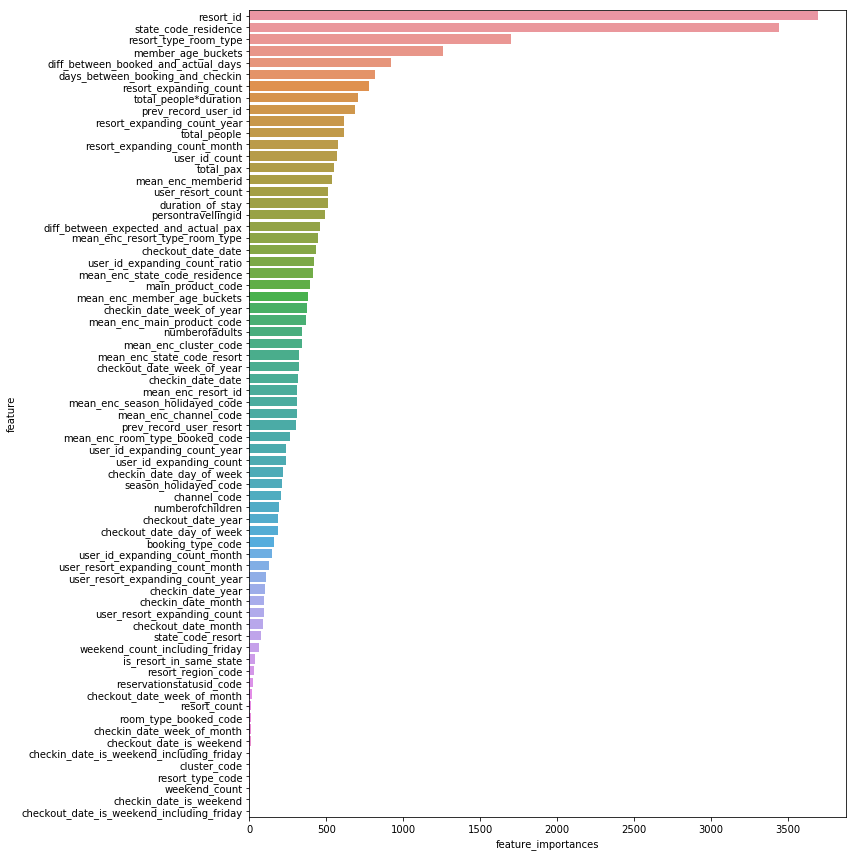

array([7.94337999, 7.76735245, 7.13606444, ..., 7.45272281, 7.3256858 ,
       8.0444475 ])

In [40]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.987161	valid_1's rmse: 0.986717
[200]	training's rmse: 0.973499	valid_1's rmse: 0.974981
[300]	training's rmse: 0.968282	valid_1's rmse: 0.971141
[400]	training's rmse: 0.965306	valid_1's rmse: 0.969478
[500]	training's rmse: 0.963132	valid_1's rmse: 0.968544
[600]	training's rmse: 0.961401	valid_1's rmse: 0.967993
[700]	training's rmse: 0.959896	valid_1's rmse: 0.967719
[800]	training's rmse: 0.958551	valid_1's rmse: 0.967499
[900]	training's rmse: 0.957232	valid_1's rmse: 0.967384
[1000]	training's rmse: 0.956003	valid_1's rmse: 0.967277
[1100]	training's rmse: 0.954832	valid_1's rmse: 0.967144
[1200]	training's rmse: 0.953732	valid_1's rmse: 0.967062
[1300]	training's rmse: 0.952633	valid_1's rmse: 0.96697
[1400]	training's rmse: 0.951628	valid_1's rmse: 0.966846
[1500]	training's rmse: 0.950692	valid_1's rmse: 0.966715
[1600]	training's rmse: 0.949753	valid_1's rmse: 0.966642
[1700]	training's r

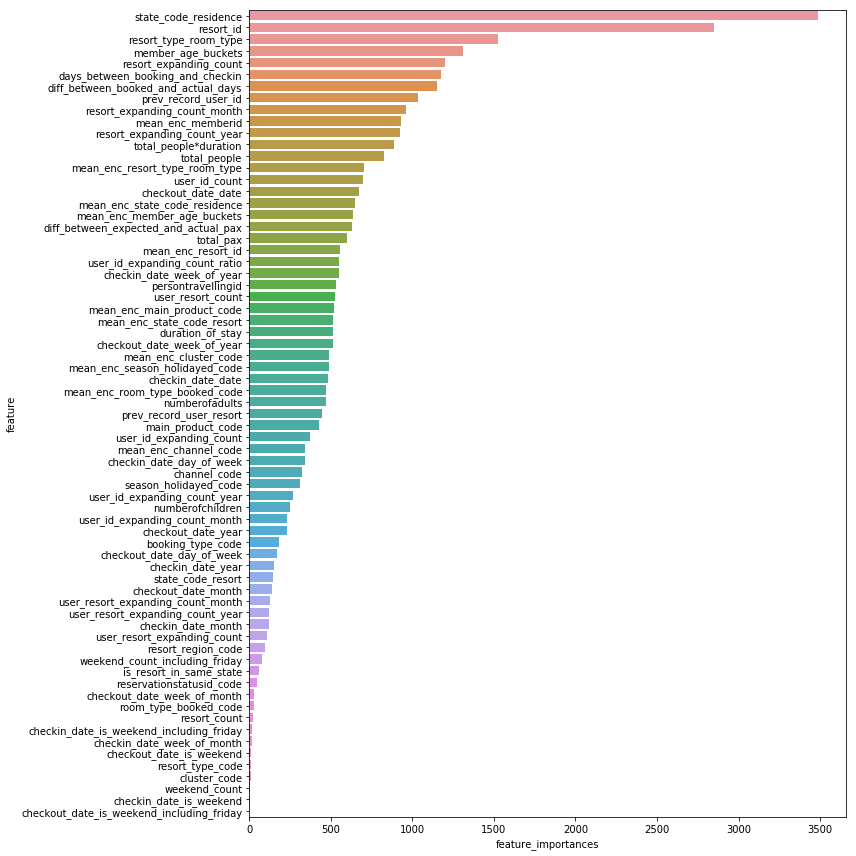

array([7.96404045, 7.75319724, 7.16925191, ..., 7.5105635 , 7.33520946,
       8.11304626])

In [42]:
lgb_params = {
    'random_state': 11,
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'subsample': 0.4,
    'colsample_bytree': 0.8,
    'reg_alpha': 10,
    'reg_lambda': 0.01,
    'min_split_gain': 0.2,
    'min_child_weight': 10,
    'n_estimators': 5000,
    'silent': 1,
    'verbose': 1,
    'max_depth': 4
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

## Submitted till here

### From rank 4 solution

/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/shashankwadhwa/Desktop/Work/env/ds3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 37, 39]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.03884	valid_1's rmse: 1.0383
[200]	training's rmse: 1.0113	valid_1's rmse: 1.01114
[300]	training's rmse: 0.994831	valid_1's rmse: 0.995154
[400]	training's rmse: 0.98546	valid_1's rmse: 0.986345
[500]	training's rmse: 0.979553	valid_1's rmse: 0.981136
[600]	training's rmse: 0.975266	valid_1's rmse: 0.977466
[700]	training's rmse: 0.972007	valid_1's rmse: 0.974847
[800]	training's rmse: 0.969647	valid_1's rmse: 0.973078
[900]	training's rmse: 0.967736	valid_1's rmse: 0.971842
[1000]	training's rmse: 0.966121	valid_1's rmse: 0.970871
[1100]	training's rmse: 0.964658	valid_1's rmse: 0.970068
[1200]	training's rmse: 0.963422	valid_1's rmse: 0.969482
[1300]	training's rmse: 0.962313	valid_1's rmse: 0.96902
[1400]	training's rmse: 0.96135	valid_1's rmse: 0.968679
[1500]	training's rmse: 0.960396	valid_1's rmse: 0.968375
[1600]	training's rmse: 0.959504	valid_1's rmse: 0.96808
[1700]	training's rmse: 0.95

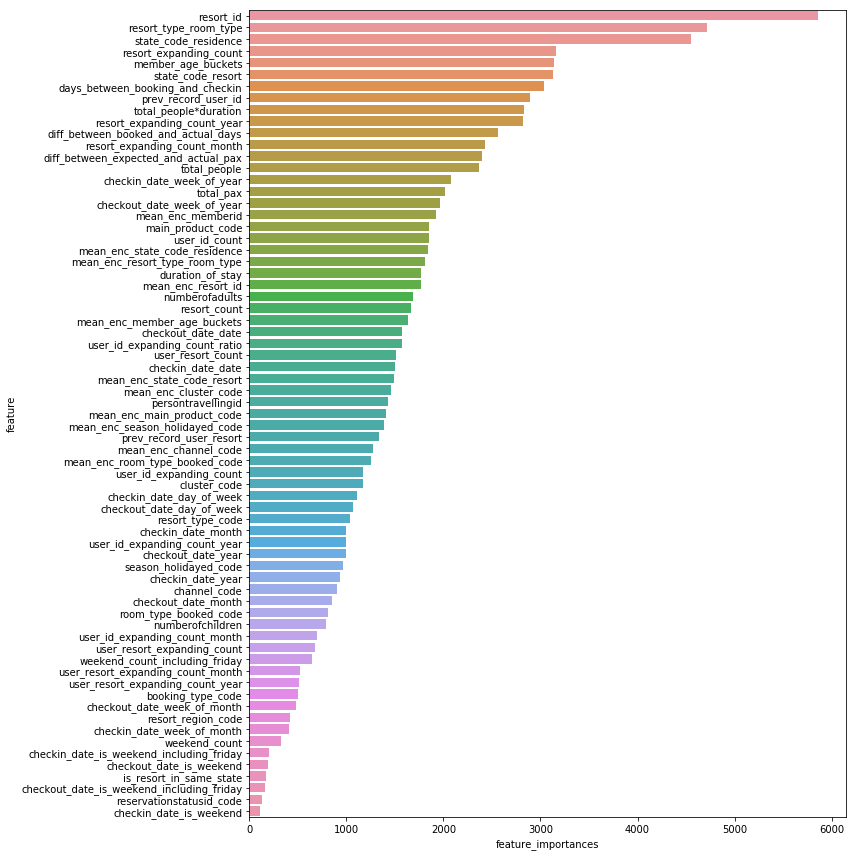

array([8.01908279, 7.70384359, 7.10134278, ..., 7.46357893, 7.34035754,
       8.09437042])

In [45]:
lgb_params = {
    'random_state': 11,
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6,
    'num_leaves': 30,
    'min_data_in_leaf': 200,
    'learning_rate': 0.01,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.2,
    'feature_fraction_seed': 11,
    'bagging_freq': 1,
    'bagging_seed': 11,
    'lambda_l2': 3,
    'lambda_l1': 3,
    'verbosity': -1,
    'n_estimators': 20000,
}

clf = LGBMRegressor(**lgb_params)
check_model(clf, df_train, features_2)

In [46]:
df_train.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled,is_test,booking_date_date,booking_date_month,booking_date_year,booking_date_week_of_year,booking_date_week_of_month,booking_date_day_of_week,booking_date_is_weekend,booking_date_is_weekend_including_friday,checkin_date_date,checkin_date_month,checkin_date_year,checkin_date_week_of_year,checkin_date_week_of_month,checkin_date_day_of_week,checkin_date_is_weekend,checkin_date_is_weekend_including_friday,checkout_date_date,checkout_date_month,checkout_date_year,checkout_date_week_of_year,checkout_date_week_of_month,checkout_date_day_of_week,checkout_date_is_weekend,checkout_date_is_weekend_including_friday,days_between_booking_and_checkin,...,resort_type_main_product_code,resort_region_main_product_code,resort_state_code_residence,resort_member_age_buckets,diff_between_booked_and_actual_days,is_resort_in_same_state,diff_between_expected_and_actual_pax,weekend_count,weekend_count_including_friday,user_id_count,user_id_expanding_count,user_id_expanding_count_year,user_id_expanding_count_month,user_resort,user_resort_count,user_resort_expanding_count,user_resort_expanding_count_year,user_resort_expanding_count_month,resort_count,resort_expanding_count,resort_expanding_count_year,resort_expanding_count_month,prev_record_user_id,prev_record_user_resort,prev_record_resort,user_id_expanding_count_ratio,mean_enc_channel_code,mean_enc_main_product_code,mean_enc_persontravellingid,mean_enc_resort_region_code,mean_enc_resort_type_code,mean_enc_room_type_booked_code,mean_enc_season_holidayed_code,mean_enc_state_code_residence,mean_enc_state_code_resort,mean_enc_member_age_buckets,mean_enc_booking_type_code,mean_enc_memberid,mean_enc_cluster_code,mean_enc_reservationstatusid_code,mean_enc_resort_id,mean_enc_resort_type_room_type,mean_enc_is_resort_in_same_state,mean_enc_user_resort,mean_enc_resortid_main_product_code,mean_enc_resortid_room_type_booked_code,mean_enc_resort_type_main_product_code,mean_enc_resort_region_main_product_code,mean_enc_resort_state_code_residence,mean_enc_resort_member_age_buckets
0,821a5e5313029b1bbec6ec738a1b34d6d14c82fca97c47...,2012-01-22,2012-03-08,2012-03-11,3,1,2,0,45,1,1,2,1,3.0,8,6,3,7,1,69707,5,2,5,3.218876,0,22,1,2012,3,4,7,True,True,8,3,2012,10,2,4,False,False,11,3,2012,10,2,7,True,True,46,...,5,0,195,57,-2,0,1,1,2,11,1,1,1,69707_5,3,1,1,1,31568,1,1,1,0.0,0.0,0.0,0.090909,7.802446,7.838842,7.76345,7.758007,7.747023,7.802002,7.653473,7.671186,7.881162,7.601481,7.690536,6.022192,7.695761,7.637910,7.990422,7.894879,7.697071,7.690416,8.118759,8.022268,7.896369,7.899680,7.853119,7.871116
1,a80d2fbea1195021307a13a44642855c60f46145dcf29c...,2012-01-26,2012-03-12,2012-03-18,3,2,3,0,45,1,1,3,2,2.0,5,1,3,3,2,120332,4,2,4,7.029715,0,26,1,2012,4,4,4,False,False,12,3,2012,11,2,1,False,False,18,3,2012,11,3,7,True,True,46,...,6,1,157,43,-4,0,0,1,2,3,1,1,1,120332_4,2,1,1,1,8108,1,1,1,0.0,0.0,0.0,0.333333,7.802446,7.722944,7.76345,7.758007,7.747023,7.634440,7.744519,7.674729,7.752967,7.757716,7.763058,7.690584,7.752967,7.637910,7.620980,7.624246,7.697071,7.690416,7.661096,7.581538,7.773639,7.785234,7.718654,7.617505
2,548605b68da37dd5c8555a37650910ce9f110e793b4619...,2012-02-04,2012-03-21,2012-03-25,1,3,3,1,45,3,3,2,6,2.0,4,5,3,4,1,33686,5,0,14,7.252902,0,4,2,2012,5,1,6,True,True,21,3,2012,12,3,3,False,False,25,3,2012,12,4,7,True,True,46,...,17,12,509,144,2,0,-1,1,2,2,1,1,1,33686_14,2,1,1,1,14084,1,1,1,0.0,0.0,0.0,0.500000,7.591622,7.614013,7.76345,7.520937,7.476651,7.802002,7.744519,7.647860,7.526496,7.773800,7.690536,7.690584,7.695761,7.698925,7.262866,7.487767,7.697071,7.690416,7.172435,7.272335,7.388633,7.429767,7.264879